# Plotting diurnal cycles

Quick example of how to compute and plot the average diurnal cycle for the average surface temperature of each model. First, we start up a Kubernetes cluster and client:

In [1]:
from dask_kubernetes import KubeCluster

cluster = KubeCluster(n_workers=10)
cluster

In [2]:
from dask.distributed import Client

client = Client(cluster)
client

Client Scheduler: tcp://10.51.186.3:46009 Dashboard: /user/charlesbluca-pa-racmip-examples-cym9o64d/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


Then we open up the preexisting catalog of TRACMIP data:

In [3]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-bot/pangeo-datastore/master/master.yaml").search("tracmip")
cat

<Intake catalog: master_search>

Create our dataframe and view it with `qgrid` widget:

In [4]:
from pandas import DataFrame
from qgrid import show_grid

df = DataFrame({"frequency"  : [item.split(".")[1] for item in list(cat)],
                "experiment" : [item.split(".")[2] for item in list(cat)],
                "model"      : [item.split(".")[3] for item in list(cat)],
                "variable"   : [item.split(".")[4] for item in list(cat)],
                "version"    : [item.split(".")[5] for item in list(cat)],
                "source"     : [cat[item] for item in list(cat)]})

qg = show_grid(df)
qg

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

After selecting our desired data using the widget, pull it in:

In [6]:
sources = [item.to_dask() for item in qg.get_changed_df()["source"]]
len(sources)

6

Finally, we can use this data to generate a rough plot of the average diurnal cycle over different regions of each model:

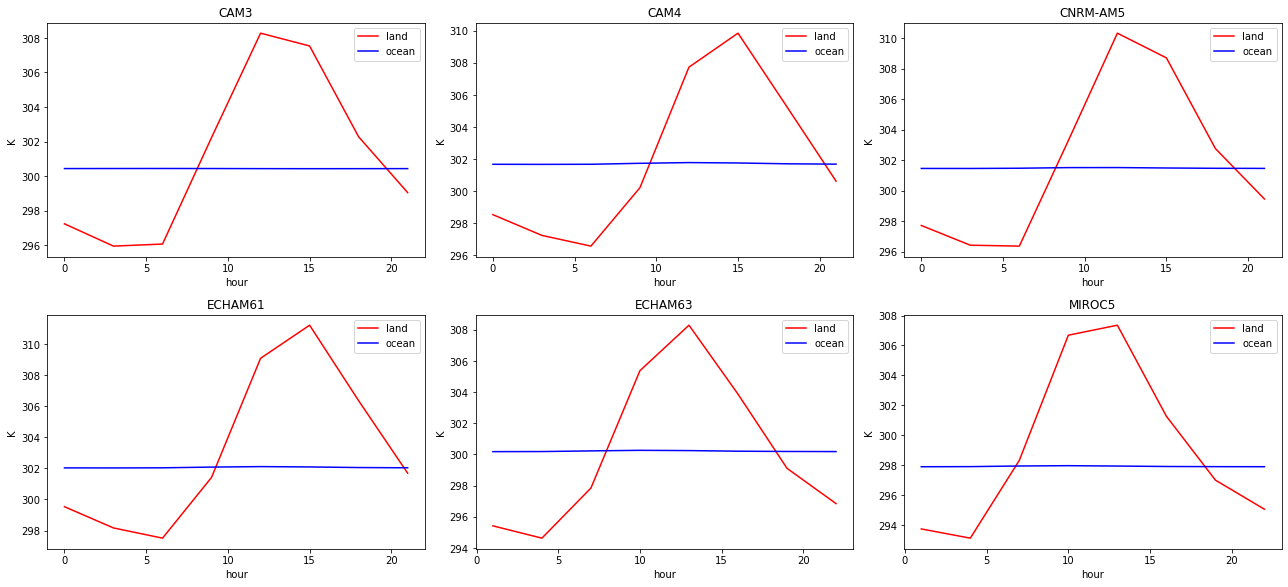

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(18, 20), facecolor='w', edgecolor='k')

for i, source in enumerate(sources):
    ax = plt.subplot(5, 3, i + 1)
    source["ts"].sel(lon=slice(0,45), lat=slice(-30,30)) \
                .groupby("time.hour").mean(dim=("time", "lat", "lon")) \
                .plot(color="red", label="land")
    source["ts"].sel(lon=slice(45,360), lat=slice(-30,30)) \
                .groupby("time.hour").mean(dim=("time", "lat", "lon")) \
                .plot(color="blue", label="ocean")
    ax.set(title=source.attrs["model_id"], ylabel=source["ts"].attrs["units"])
    ax.legend()
    
plt.tight_layout()